# Intersection Crash Analysis Using Only Intersection Characteristics

Linear regression analysis of factors affecting red light crashes

In [368]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [369]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [370]:
print(sql_fetch_tables(c, conn))
#table_info(c, conn)  # use if you need to see columns

[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('all_days',), ('all_hours',)]


## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [852]:
table_info(c, conn)

cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-crash_hour
	-crash_day_of_week
	-crash_month
	-latitude
	-longitude
	-lane_cnt
	-interse

In [871]:
#create my db
crash_df = pd.read_sql_query('''
WITH v AS(SELECT dv.intersection,
                SUM(dv.violations) as violations,
                (CASE
                      WHEN JulianDay(se.start) <= JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST(JulianDay('2020-12-31 00:00:00') - JulianDay('2017-09-01 00:00:00') as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST (JulianDay('2020-12-31 00:00:00') - JulianDay(se.start) as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) <= JulianDay('2020-12-31 00:00:00')
                          THEN CAST ((se.end) - JulianDay(se.start) as Integer)
                    
                      ELSE CAST (JulianDay(se.end) - JulianDay('2017-09-01 00:00:00') as Integer)
                END) AS days_active,
                COUNT(DISTINCT dv.camera_id) as n_cams,
                start,
                end,
                day,
                dv.month,
                dv.year,
                dv.intersection

        FROM daily_violations as dv
        LEFT JOIN int_startend as se
            ON se.intersection = dv.intersection

        GROUP BY dv.year, dv.month, dv.day, dv.intersection
        ), 

    ic AS(SELECT *
         FROM intersection_chars
        ),

    cr AS(SELECT *   
         FROM signal_crashes
         GROUP BY year, month, day, intersection
        ),
    
    ah AS(SELECT * FROM all_hours GROUP BY year, month, day, intersection),
    
    rg AS(SELECT region_id, intersection
        FROM intersection_cams
        GROUP BY intersection)

SELECT 
    (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / 1217) as injuries_per_year,
    (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ 1217) as crash_per_year,
    ( (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ 1217) +
      (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / 1217) +
      (CAST(365 * SUM(cr.injuries_incapacitating) AS FLOAT) / 1217)) AS danger_metric,

    (CAST(v.days_active AS FLOAT) / 1217) AS active_cam,
    
    (CAST((ic.daily_traffic/ic.total_lanes) AS FLOAT)) as traffic_per_lane,
    ic.protected_turn/ic.way as protected_ratio,

    (ic.exit + ic.triangle + ic.angled + ic.one_way + ic.underpass) as complexity,

    ic.*,
    
    v.n_cams,
    (CAST(365 * SUM(v.violations) AS FLOAT) / v.days_active) as violations_per_year,
    COUNT(crash_record_id) as n_crash,
    SUM(injuries_total) as injuries_total,
    SUM(injuries_fatal) as injuries_fatal,
    SUM(injuries_non_incapacitating) as injuries_non_incapacitating,
    v.days_active,
    (CAST(ic.total_lanes AS FLOAT)/ic.way) AS lanes_per_direction,  
    
    rg.region_id

FROM ah
LEFT JOIN v
    ON v.year = ah.year
    AND v.month = ah.month
    AND v.day = ah.day
    AND v.intersection = ah.intersection
LEFT JOIN cr
    ON cr.year = ah.year
    AND cr.month = ah.month
    AND cr.day = ah.day
    AND cr.intersection = ah.intersection
LEFT JOIN ic
    ON ah.intersection = ic.intersection
LEFT JOIN rg
    ON ah.intersection = rg.intersection
WHERE cr.crash_date >= \'2017-09-01\' AND cr.crash_date <= \'2020-12-31\'
GROUP BY ic.intersection
ORDER BY ic.intersection
                                    ''', conn)

crash_df.head()

,injuries_per_year,crash_per_year,danger_metric,active_cam,traffic_per_lane,traffic,protected_ratio,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,intersection,daily_traffic,speed,n_cams,violations_per_year,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,days_active,lanes_per_direction,region_id
0,10.197206,13.496302,24.593262,1.0,7183.0,43100,0,1,2,6,2,0,0,4,0,0,1,0,0,2,41.692362,-87.642423,1,111TH AND HALSTED,43100,35,2.0,161.355793,45,34,0,18,1217.0,1.5,26
1,6.298274,11.396878,17.995070,1.0,6966.0,41800,1,0,4,6,2,0,0,4,0,0,0,0,0,4,41.677774,-87.641930,1,119TH AND HALSTED,41800,35,2.0,133.463435,38,21,0,11,1217.0,1.5,26
2,5.698439,13.196385,19.194741,1.0,3650.0,36500,0,0,2,10,2,0,1,4,0,2,0,0,0,0,41.838441,-87.617338,1,31ST ST AND MARTIN LUTHER KING DRIVE,36500,35,2.0,200.345111,44,19,0,11,1217.0,2.5,16
3,5.698439,20.394412,26.392769,1.0,5300.0,42400,0,0,2,8,2,0,1,4,0,0,0,0,0,2,41.830281,-87.684775,1,35TH AND WESTERN,42400,35,2.0,125.965489,68,19,0,14,1217.0,2.0,15
4,9.897288,35.090386,45.587510,1.0,4900.0,58800,0,0,3,12,2,0,1,4,0,0,0,0,0,2,41.808442,-87.684183,1,4700 WESTERN,58800,40,2.0,190.147905,117,33,0,19,1217.0,3.0,18


In [872]:
crash_df.describe()

,injuries_per_year,crash_per_year,danger_metric,active_cam,traffic_per_lane,traffic,protected_ratio,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed,n_cams,violations_per_year,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,days_active,lanes_per_direction
count,155.000000,155.000000,155.000000,142.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.00000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.0,155.000000,155.000000,142.000000,142.000000,155.000000,155.000000,155.000000,155.000000,142.000000,155.000000
mean,4.663239,11.843852,16.996634,0.993091,8092.909677,51365.161290,0.348387,0.754839,2.187097,6.612903,0.419355,0.116129,0.051613,4.103226,0.135484,0.23871,0.135484,0.161290,0.206452,3.290323,41.882855,-87.698508,1.0,51365.161290,35.709677,1.880282,137.367708,39.490323,15.548387,0.090323,9.032258,1208.591549,1.618602
std,3.673259,7.169845,10.521973,0.080131,2225.178497,14524.330655,0.478004,1.207885,1.610788,1.904837,0.771833,0.321418,0.221961,0.458317,0.442505,0.62506,0.343349,0.368991,0.566337,1.284107,0.082998,0.051176,0.0,14524.330655,3.532719,0.385599,184.599015,23.906030,12.247551,0.400774,7.324057,97.519458,0.456178
min,0.000000,0.599836,0.899753,0.045193,3011.000000,21600.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,41.677774,-87.812226,1.0,21600.000000,30.000000,1.000000,2.999178,2.000000,0.000000,0.000000,0.000000,55.000000,1.000000
25%,2.399343,7.647905,10.797042,1.000000,6599.500000,42150.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,41.812596,-87.735649,1.0,42150.000000,35.000000,2.000000,39.964051,25.500000,8.000000,0.000000,4.500000,1217.000000,1.500000
50%,3.599014,10.197206,15.595727,1.000000,8080.000000,49600.000000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,41.903623,-87.699390,1.0,49600.000000,35.000000,2.000000,68.981101,34.000000,12.000000,0.000000,7.000000,1217.000000,1.500000
75%,5.698439,14.695974,20.394412,1.000000,9656.000000,58300.000000,1.000000,1.000000,4.000000,8.000000,0.500000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,41.946002,-87.662868,1.0,58300.000000,35.000000,2.000000,143.435703,49.000000,19.000000,0.000000,11.500000,1217.000000,2.000000
max,26.992605,59.983566,90.275267,1.000000,13925.000000,105500.000000,1.000000,6.000000,4.000000,14.000000,3.000000,1.000000,1.000000,6.000000,2.000000,3.00000,1.000000,1.000000,3.000000,6.000000,42.012234,-87.575373,1.0,105500.000000,65.000000,3.000000,1021.520131,200.000000,90.000000,3.000000,43.000000,1217.000000,3.500000


In [873]:


sql_fetch_tables(c, conn)

[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('intersection_cams',),
 ('int_startend',),
 ('intersection_chars',),
 ('signal_crashes',),
 ('all_days',),
 ('all_hours',)]

In [874]:
crash_df.drop_duplicates(inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a single dupe column preventing modeling
crash_df.describe()

,injuries_per_year,crash_per_year,danger_metric,active_cam,traffic_per_lane,traffic,protected_ratio,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed,n_cams,violations_per_year,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,days_active,lanes_per_direction
count,155.000000,155.000000,155.000000,142.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.00000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.0,155.000000,155.000000,142.000000,142.000000,155.000000,155.000000,155.000000,155.000000,142.000000,155.000000
mean,4.663239,11.843852,16.996634,0.993091,8092.909677,51365.161290,0.348387,0.754839,2.187097,6.612903,0.419355,0.116129,0.051613,4.103226,0.135484,0.23871,0.135484,0.161290,0.206452,3.290323,41.882855,-87.698508,1.0,51365.161290,35.709677,1.880282,137.367708,39.490323,15.548387,0.090323,9.032258,1208.591549,1.618602
std,3.673259,7.169845,10.521973,0.080131,2225.178497,14524.330655,0.478004,1.207885,1.610788,1.904837,0.771833,0.321418,0.221961,0.458317,0.442505,0.62506,0.343349,0.368991,0.566337,1.284107,0.082998,0.051176,0.0,14524.330655,3.532719,0.385599,184.599015,23.906030,12.247551,0.400774,7.324057,97.519458,0.456178
min,0.000000,0.599836,0.899753,0.045193,3011.000000,21600.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,41.677774,-87.812226,1.0,21600.000000,30.000000,1.000000,2.999178,2.000000,0.000000,0.000000,0.000000,55.000000,1.000000
25%,2.399343,7.647905,10.797042,1.000000,6599.500000,42150.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,41.812596,-87.735649,1.0,42150.000000,35.000000,2.000000,39.964051,25.500000,8.000000,0.000000,4.500000,1217.000000,1.500000
50%,3.599014,10.197206,15.595727,1.000000,8080.000000,49600.000000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,41.903623,-87.699390,1.0,49600.000000,35.000000,2.000000,68.981101,34.000000,12.000000,0.000000,7.000000,1217.000000,1.500000
75%,5.698439,14.695974,20.394412,1.000000,9656.000000,58300.000000,1.000000,1.000000,4.000000,8.000000,0.500000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,41.946002,-87.662868,1.0,58300.000000,35.000000,2.000000,143.435703,49.000000,19.000000,0.000000,11.500000,1217.000000,2.000000
max,26.992605,59.983566,90.275267,1.000000,13925.000000,105500.000000,1.000000,6.000000,4.000000,14.000000,3.000000,1.000000,1.000000,6.000000,2.000000,3.00000,1.000000,1.000000,3.000000,6.000000,42.012234,-87.575373,1.0,105500.000000,65.000000,3.000000,1021.520131,200.000000,90.000000,3.000000,43.000000,1217.000000,3.500000


In [875]:
# need to drop all of the rows I don't have data for
try:
    crash_df.dropna(subset=['crash_record_id'], inplace=True)
except Exception as e:
    print(e)

['crash_record_id']


In [876]:
# now drop out the rows that do not have daily violations. Should cure all our nans
# Some of these cams were only running before our query.
crash_df.dropna(subset=['violations_per_year'], inplace=True)
crash_df.dropna(subset=['intersection'], inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (danger)

In [877]:
df_final = crash_df.copy()  # so I don't change my dataset
df_final.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric', 'active_cam',
       'traffic_per_lane', 'traffic', 'protected_ratio', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'speed',
       'n_cams', 'violations_per_year', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_non_incapacitating', 'days_active',
       'lanes_per_direction', 'region_id'],
      dtype='object')

## Single variable regression


CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.001e+32
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:16:27   Log-Likelihood:                 4533.2
No. Observations:                 142   AIC:                            -9062.
Df Residuals:                     140   BIC:                            -9056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025    

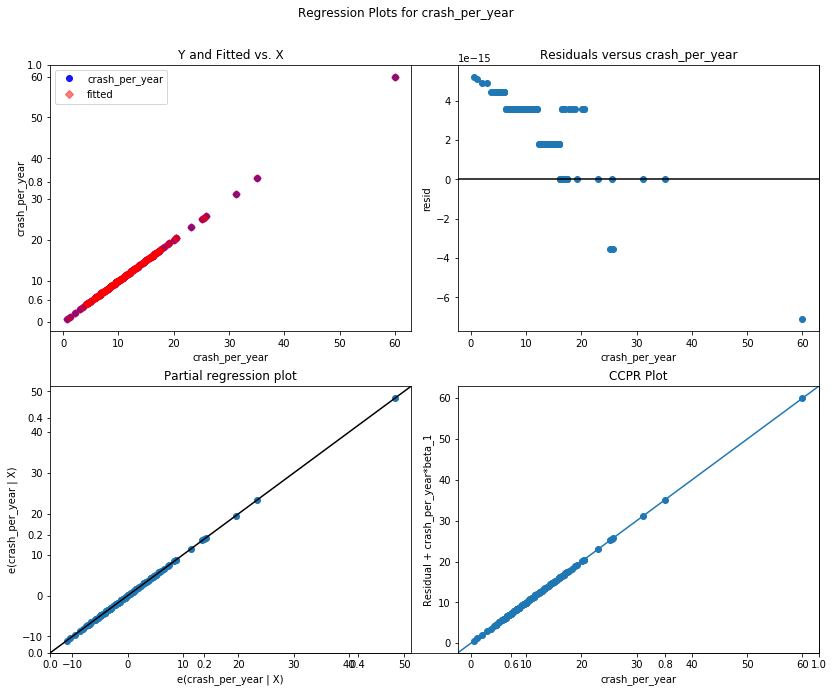

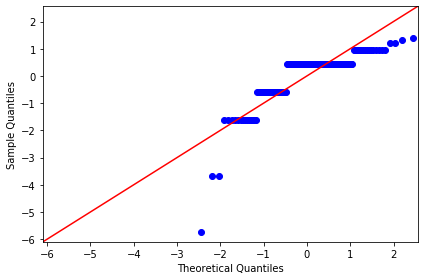


TRAFFIC **** TRAFFIC **** TRAFFIC **** TRAFFIC **** TRAFFIC **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     15.77
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           0.000114
Time:                        17:16:29   Log-Likelihood:                -467.07
No. Observations:                 142   AIC:                             938.1
Df Residuals:                     140   BIC:                             944.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

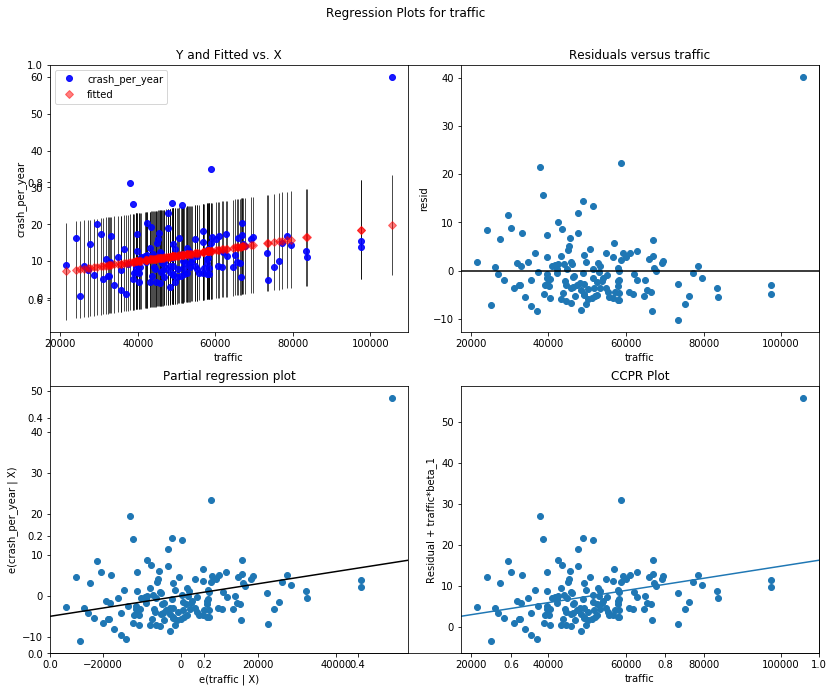

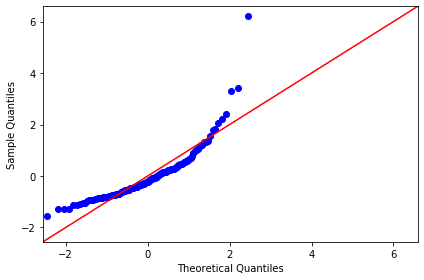


PROTECTED_TURN **** PROTECTED_TURN **** PROTECTED_TURN **** PROTECTED_TURN **** PROTECTED_TURN **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1885
Date:                Mon, 22 Feb 2021   Prob (F-statistic):              0.665
Time:                        17:16:31   Log-Likelihood:                -474.55
No. Observations:                 142   AIC:                             953.1
Df Residuals:                     140   BIC:                             959.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025    

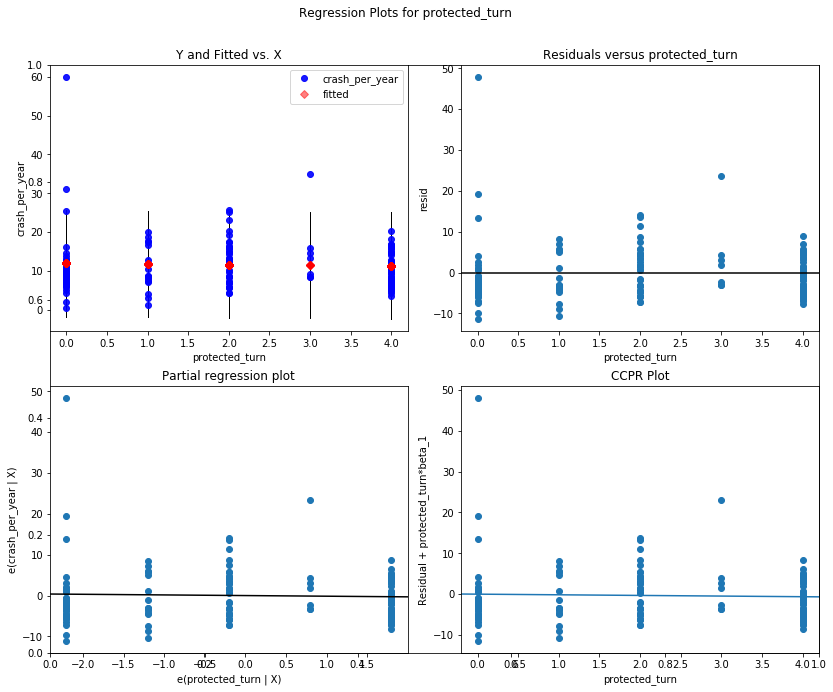

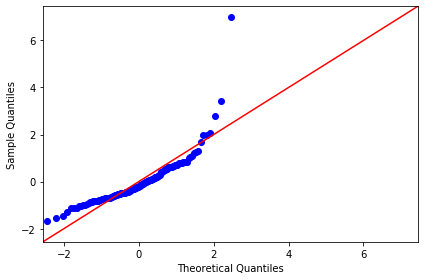


TOTAL_LANES **** TOTAL_LANES **** TOTAL_LANES **** TOTAL_LANES **** TOTAL_LANES **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     59.53
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           2.06e-12
Time:                        17:16:33   Log-Likelihood:                -449.49
No. Observations:                 142   AIC:                             903.0
Df Residuals:                     140   BIC:                             908.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------

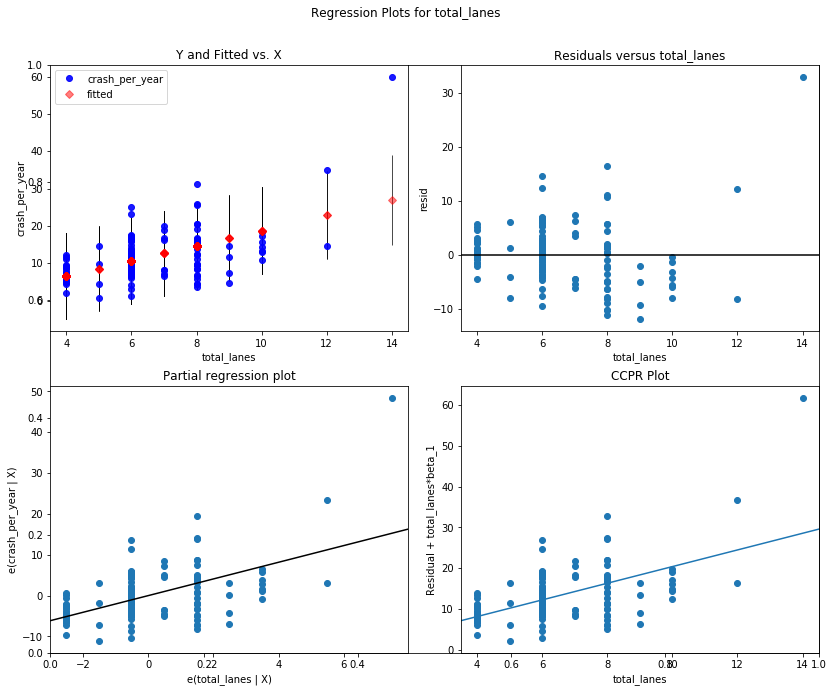

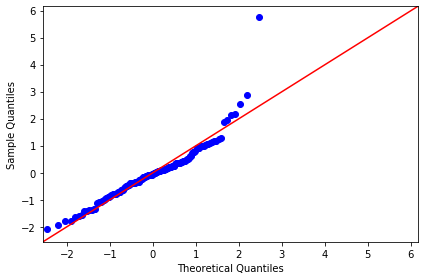


MEDIANS **** MEDIANS **** MEDIANS **** MEDIANS **** MEDIANS **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     12.89
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           0.000457
Time:                        17:16:35   Log-Likelihood:                -468.40
No. Observations:                 142   AIC:                             940.8
Df Residuals:                     140   BIC:                             946.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

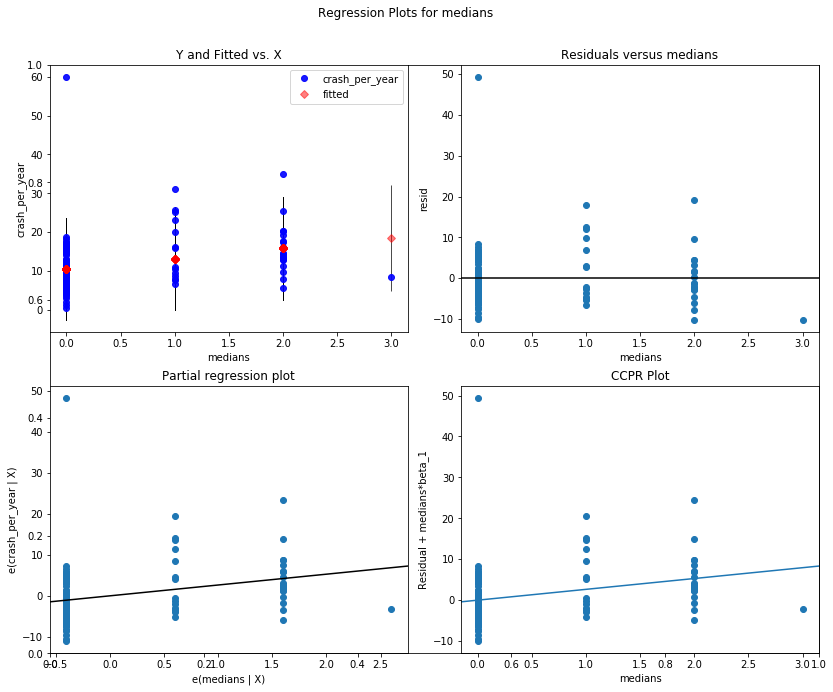

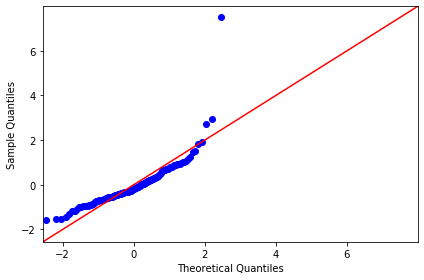


WAY **** WAY **** WAY **** WAY **** WAY **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.707
Date:                Mon, 22 Feb 2021   Prob (F-statistic):             0.0317
Time:                        17:16:36   Log-Likelihood:                -472.30
No. Observations:                 142   AIC:                             948.6
Df Residuals:                     140   BIC:                             954.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

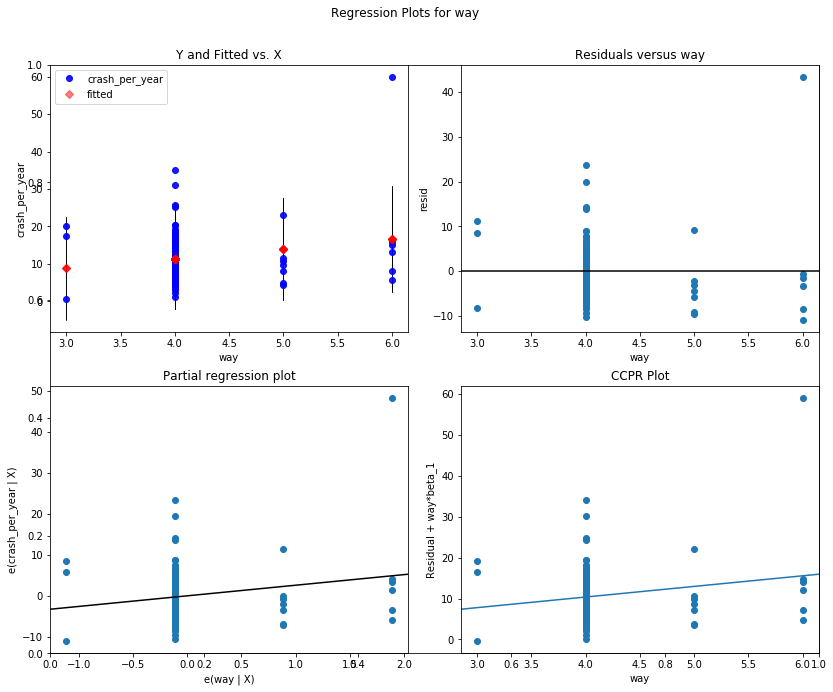

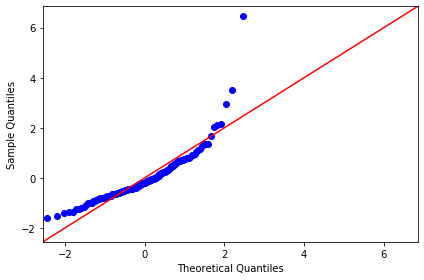


TURN_LANES **** TURN_LANES **** TURN_LANES **** TURN_LANES **** TURN_LANES **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2506
Date:                Mon, 22 Feb 2021   Prob (F-statistic):              0.617
Time:                        17:16:38   Log-Likelihood:                -474.52
No. Observations:                 142   AIC:                             953.0
Df Residuals:                     140   BIC:                             959.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

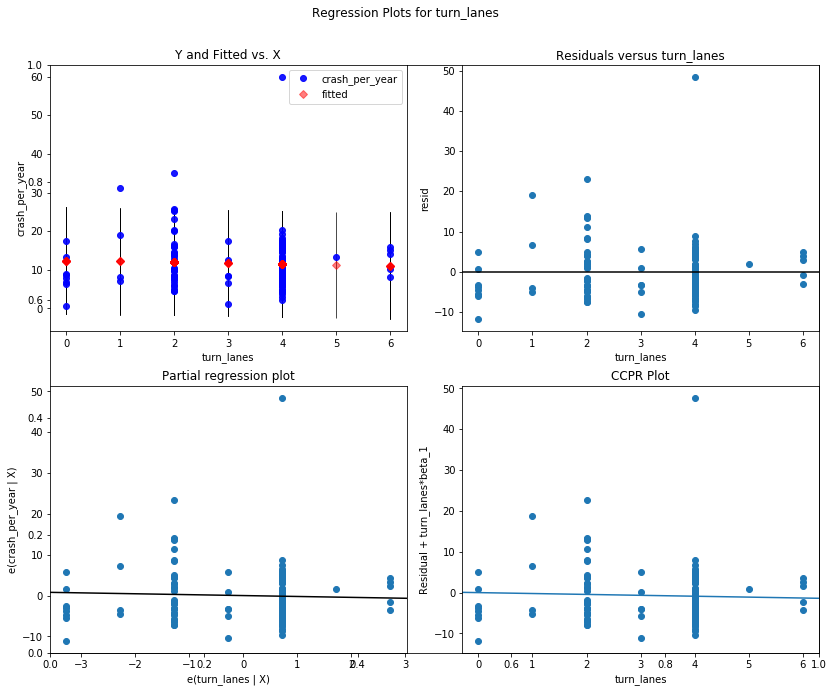

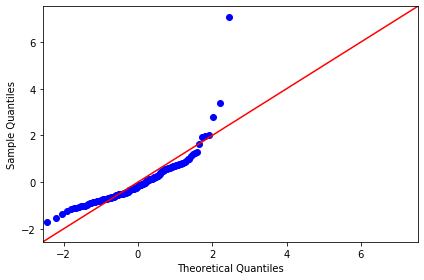


SPEED **** SPEED **** SPEED **** SPEED **** SPEED **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     18.50
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           3.17e-05
Time:                        17:16:41   Log-Likelihood:                -465.84
No. Observations:                 142   AIC:                             935.7
Df Residuals:                     140   BIC:                             941.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

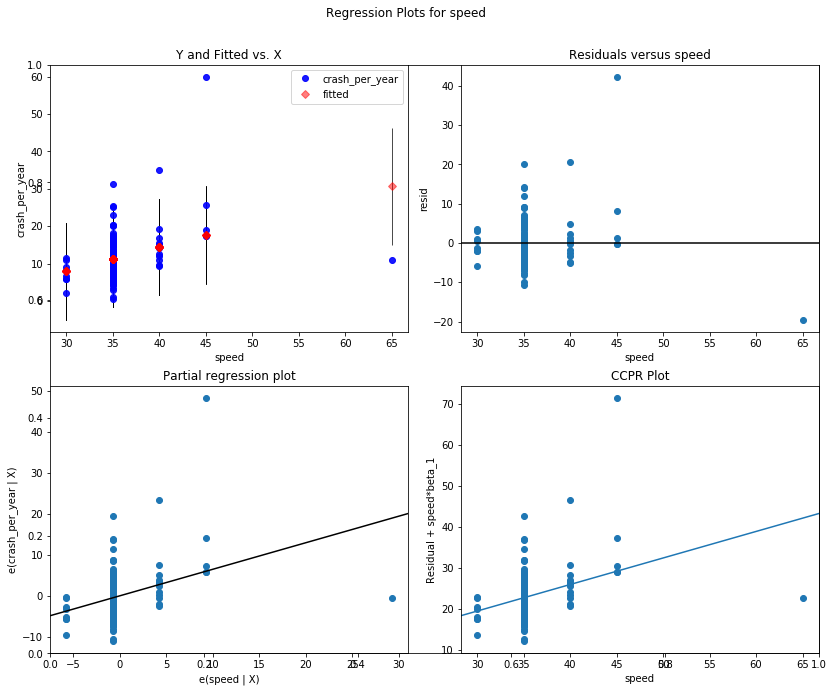

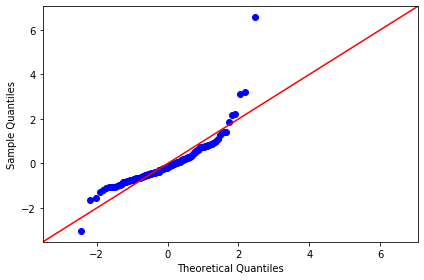


VIOLATIONS_PER_YEAR **** VIOLATIONS_PER_YEAR **** VIOLATIONS_PER_YEAR **** VIOLATIONS_PER_YEAR **** VIOLATIONS_PER_YEAR **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     78.82
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           2.94e-15
Time:                        17:16:43   Log-Likelihood:                -442.94
No. Observations:                 142   AIC:                             889.9
Df Residuals:                     140   BIC:                             895.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err        

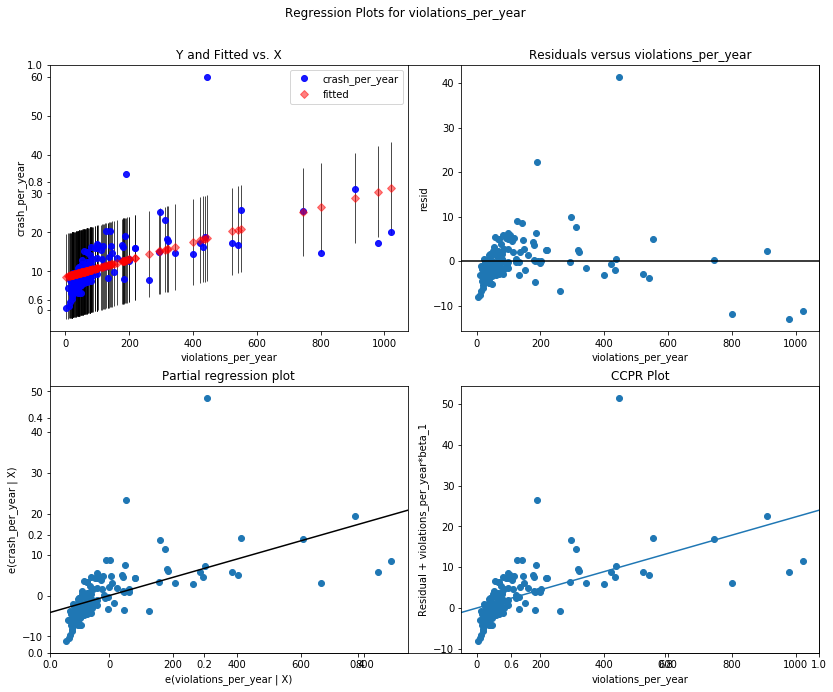

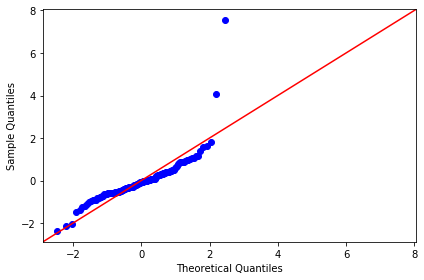


N_CAMS **** N_CAMS **** N_CAMS **** N_CAMS **** N_CAMS **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9373
Date:                Mon, 22 Feb 2021   Prob (F-statistic):              0.335
Time:                        17:16:45   Log-Likelihood:                -474.17
No. Observations:                 142   AIC:                             952.3
Df Residuals:                     140   BIC:                             958.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

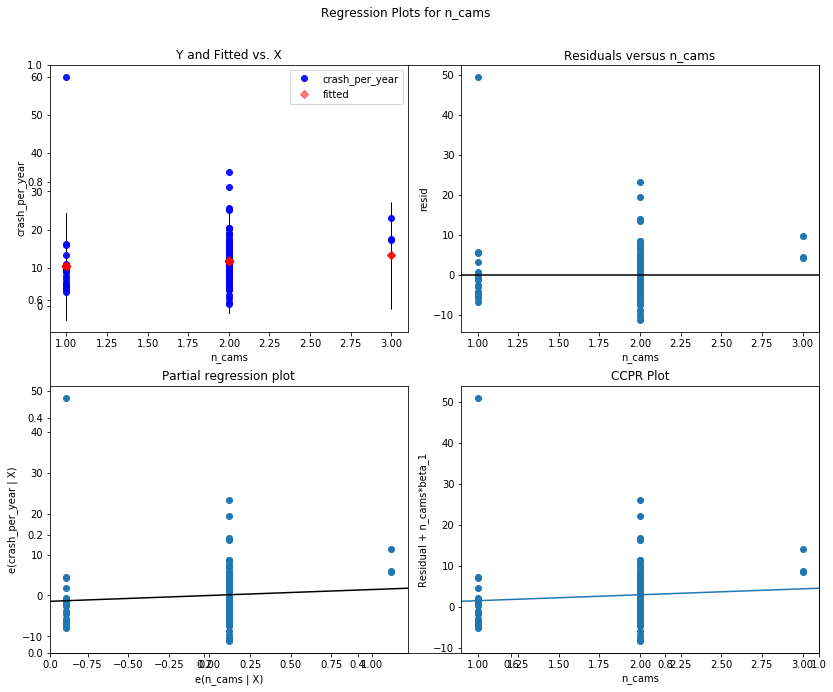

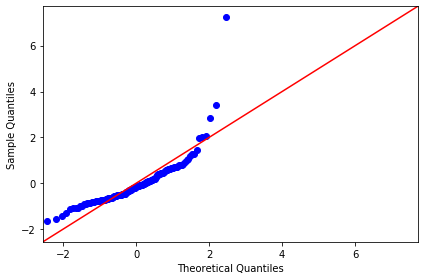


ONE_WAY **** ONE_WAY **** ONE_WAY **** ONE_WAY **** ONE_WAY **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     8.525
Date:                Mon, 22 Feb 2021   Prob (F-statistic):            0.00408
Time:                        17:16:47   Log-Likelihood:                -470.45
No. Observations:                 142   AIC:                             944.9
Df Residuals:                     140   BIC:                             950.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

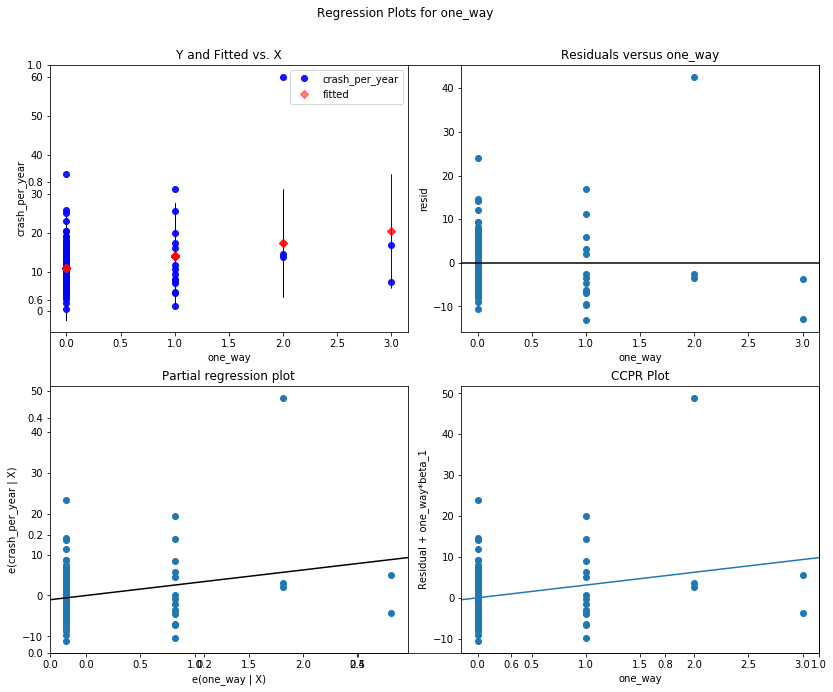

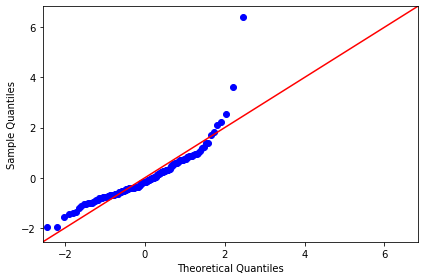


TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     6.716
Date:                Mon, 22 Feb 2021   Prob (F-statistic):             0.0106
Time:                        17:16:48   Log-Likelihood:                -471.32
No. Observations:                 142   AIC:                             946.6
Df Residuals:                     140   BIC:                             952.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|    

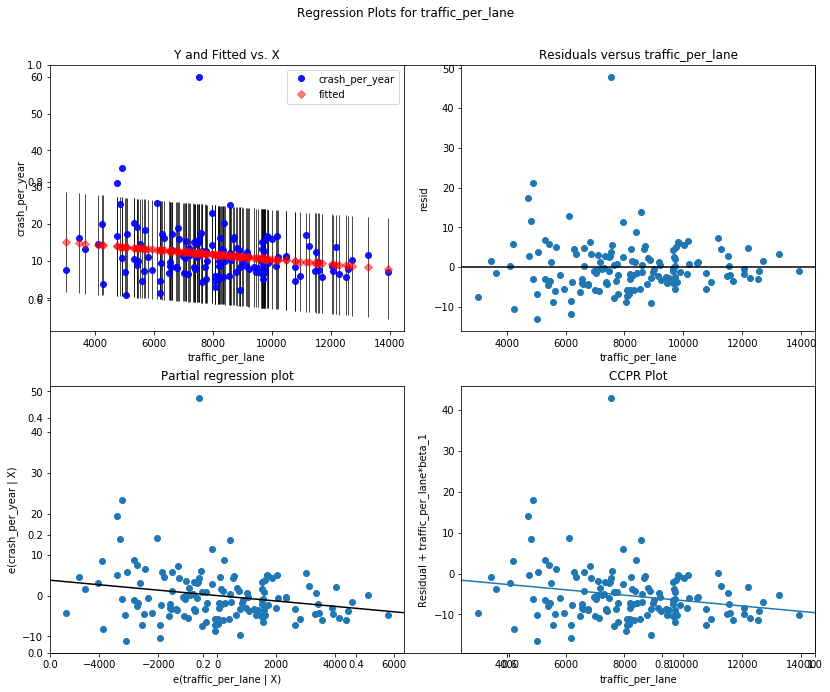

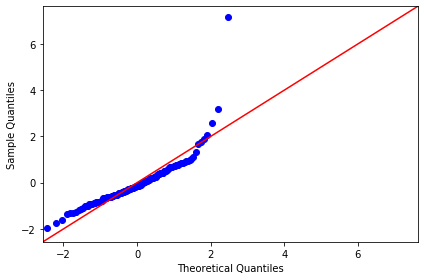


PROTECTED_RATIO **** PROTECTED_RATIO **** PROTECTED_RATIO **** PROTECTED_RATIO **** PROTECTED_RATIO **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.134
Date:                Mon, 22 Feb 2021   Prob (F-statistic):              0.289
Time:                        17:16:50   Log-Likelihood:                -474.07
No. Observations:                 142   AIC:                             952.1
Df Residuals:                     140   BIC:                             958.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.0

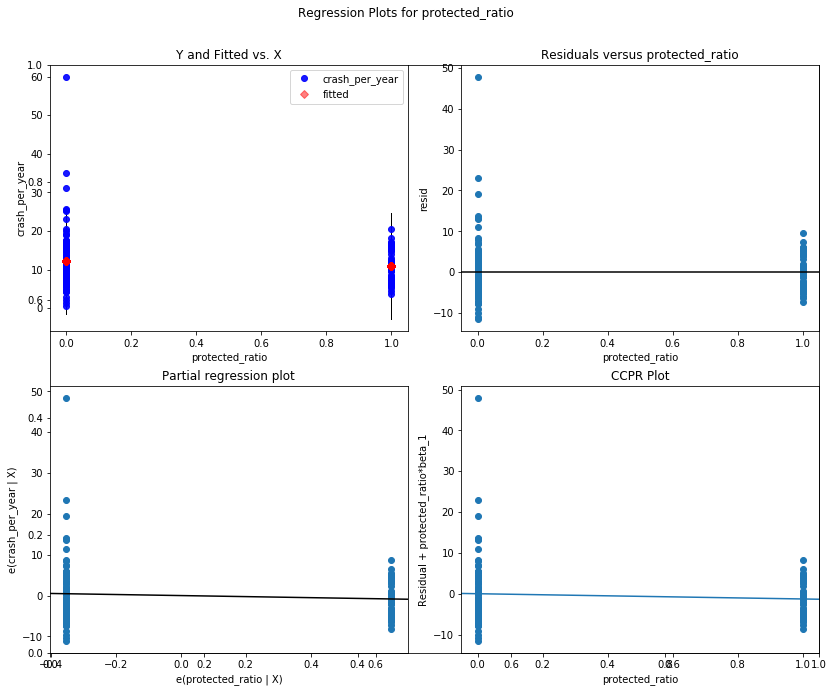

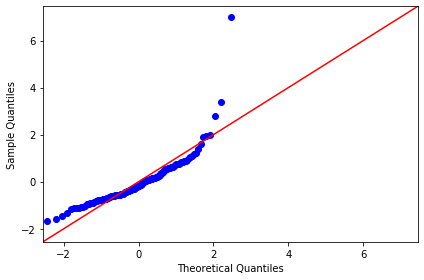


LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     37.69
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           8.07e-09
Time:                        17:16:52   Log-Likelihood:                -457.72
No. Observations:                 142   AIC:                             919.4
Df Residuals:                     140   BIC:                             925.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err        

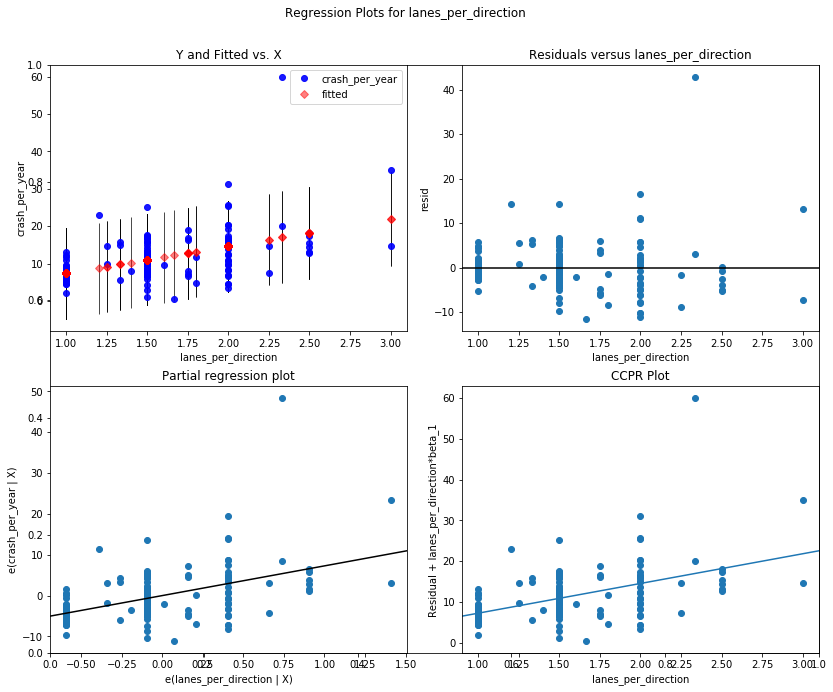

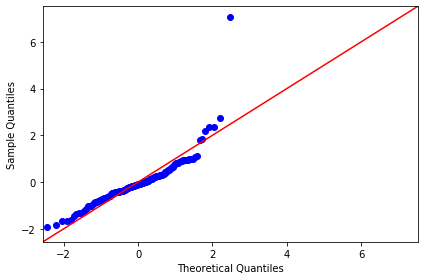


ACTIVE_CAM **** ACTIVE_CAM **** ACTIVE_CAM **** ACTIVE_CAM **** ACTIVE_CAM **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.05594
Date:                Mon, 22 Feb 2021   Prob (F-statistic):              0.813
Time:                        17:16:54   Log-Likelihood:                -474.62
No. Observations:                 142   AIC:                             953.2
Df Residuals:                     140   BIC:                             959.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

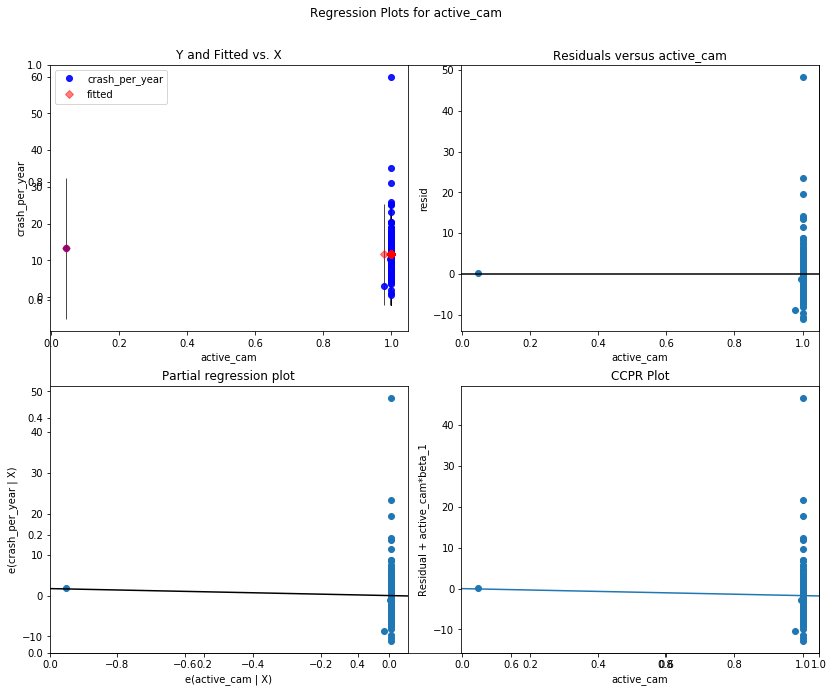

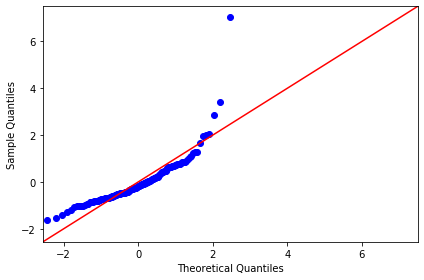

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
14,active_cam,0.000399,1.337310e+01,-1.713484,8.133752e-01,1869.537416
2,protected_turn,0.001344,1.201650e+01,-0.156540,6.648773e-01,1764.970974
6,turn_lanes,0.001787,1.239392e+01,-0.220626,6.174417e-01,1897.831153
9,n_cams,0.006650,8.939506e+00,1.452944,3.346497e-01,2333.800596
12,protected_ratio,0.008035,1.212385e+01,-1.284822,2.887425e-01,1757.096403
5,way,0.032526,1.007860e+00,2.592859,3.173324e-02,960.000888
11,traffic_per_lane,0.045776,1.705745e+01,-0.000662,1.056778e-02,2002.814378
10,one_way,0.057395,1.110019e+01,3.119964,4.084751e-03,909.731456
4,medians,0.084281,1.060937e+01,2.645878,4.571482e-04,2945.730631
1,traffic,0.101231,4.087826e+00,0.000148,1.140102e-04,778.120031


In [878]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'crash_per_year'


continuous = [target, 'protected_turn', 'total_lanes', 
              'medians', 'way','turn_lanes', 'speed', 
              'violations_per_year', 'n_cams', 'one_way', 'traffic_per_lane', 'protected_ratio',
             'lanes_per_direction', 'active_cam']


categoricals = ['exit', 'split', 'underpass', 'angled', 'triangle', 'no_left', 'region_id']



df_cont = df_final[continuous]



results = []

for idx, column in enumerate(df_cont.columns):
    print()
    print((column.upper() + " **** ") * 5)
    print ("Red Light Camera Crash - Injuries")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(12,10))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

In [879]:
df_cont.corr()  # create a correlation matrix

,crash_per_year,traffic,protected_turn,total_lanes,medians,way,turn_lanes,speed,violations_per_year,n_cams,one_way,traffic_per_lane,protected_ratio,lanes_per_direction,active_cam
crash_per_year,1.000000,0.318168,-0.036664,0.546201,0.290312,0.180349,-0.042270,0.341623,0.600159,0.081549,0.239572,-0.213952,-0.089640,0.460556,-0.019986
traffic,0.318168,1.000000,0.328756,0.509931,0.085925,0.302889,0.290049,0.289346,-0.065609,-0.034999,0.014003,0.459320,0.317096,0.384753,-0.009536
protected_turn,-0.036664,0.328756,1.000000,0.162607,-0.114841,-0.085480,0.391897,0.065214,-0.224434,-0.086050,-0.261594,0.195243,0.825647,0.195831,-0.039780
total_lanes,0.546201,0.509931,0.162607,1.000000,0.338968,0.255371,-0.030230,0.319739,0.335460,-0.001408,0.317452,-0.483326,0.007588,0.915712,0.024592
medians,0.290312,0.085925,-0.114841,0.338968,1.000000,-0.008319,-0.319189,-0.005583,0.313467,0.117703,0.099222,-0.260208,-0.236929,0.366001,-0.177975
way,0.180349,0.302889,-0.085480,0.255371,-0.008319,1.000000,0.221065,0.033495,-0.151848,-0.118722,0.142651,0.044744,-0.174445,-0.136873,0.020475
turn_lanes,-0.042270,0.290049,0.391897,-0.030230,-0.319189,0.221065,1.000000,0.009173,-0.301729,-0.116412,-0.266997,0.325475,0.385210,-0.119986,-0.047852
speed,0.341623,0.289346,0.065214,0.319739,-0.005583,0.033495,0.009173,1.000000,0.280768,0.038468,0.077161,-0.025610,0.053257,0.310856,0.017739
violations_per_year,0.600159,-0.065609,-0.224434,0.335460,0.313467,-0.151848,-0.301729,0.280768,1.000000,0.215346,0.432405,-0.398281,-0.231956,0.428452,0.018670
n_cams,0.081549,-0.034999,-0.086050,-0.001408,0.117703,-0.118722,-0.116412,0.038468,0.215346,1.000000,-0.030937,-0.049768,-0.115658,0.072091,0.192199


In [880]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric', 'active_cam',
       'traffic_per_lane', 'traffic', 'protected_ratio', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'speed',
       'n_cams', 'violations_per_year', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_non_incapacitating', 'days_active',
       'lanes_per_direction', 'region_id'],
      dtype='object')

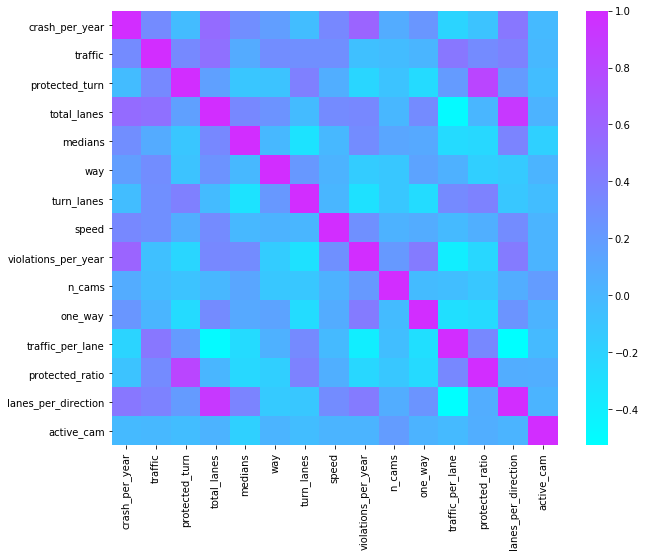

In [881]:
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [882]:
# get rid of categories that have high correlation and others.

df_continuous = df_cont.copy()
#df_ohe = crash_df[categoricals] # defined earlier
df_ohe = df_final[categoricals] # defined earlier
df_ohe[categoricals] = df_ohe[categoricals].astype(str)

# One hot encoding   
#df_ohe = pd.get_dummies(df_ohe, columns=['way'], drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

## Feature selection

In [883]:

X_ = df_final.drop(target, axis=1)  # drop my potential targets

y = df_final[target]

In [884]:
### FEATURE SELECTION

#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

ridge = Ridge()
selector = RFE(ridge, step=1)
selector = selector.fit(X_, y)
X_transformed = selector.transform(X_)

rfe_df = pd.DataFrame(list(zip(X_.columns, selector.support_, selector.ranking_, selector.estimator_.coef_)),
                  columns=['feature', 'support', 'rank', 'coef', ])

rfe_df
#rfe_df.sort_values(by=['support', 'rank'], ascending=False)

,feature,support,rank,coef
0,traffic,False,11,2.677921
1,protected_turn,False,6,-1.659142
2,total_lanes,True,1,0.759520
3,medians,False,9,1.430933
4,way,True,1,-0.750166
5,turn_lanes,True,1,-5.457219
6,speed,False,5,-2.165624
7,violations_per_year,False,10,5.837981
8,n_cams,True,1,9.122605
9,one_way,True,1,1.697552


## Apply my feature selection to data

In [885]:
#X_ = X.iloc[:,selector.support_] 
# Chose not to keep n_cams because I consider it a mitigation put in place, not inherent to intersection
keep = ['traffic', 'total_lanes', 'speed', 'violations_per_year', 'n_cams', 'one_way', 'turn_lanes', 'way']
X = X_[keep]

In [886]:
print(X.columns)
# this did not result in a positive r2 value.  I will manually select some of my features instead

Index(['traffic', 'total_lanes', 'speed', 'violations_per_year', 'n_cams',
       'one_way', 'turn_lanes', 'way'],
      dtype='object')


# Linear Regression

In [887]:
# Import statsmodels.api as sm
from statsmodels.formula.api import ols

In [888]:
pred_sum = '+'.join(X.columns)
formula = target + '~' + pred_sum

In [889]:
model = ols(formula=formula, data=pd.concat([X, y], axis=1)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         crash_per_year   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     21.44
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           1.17e-20
Time:                        17:18:13   Log-Likelihood:                -415.83
No. Observations:                 142   AIC:                             849.7
Df Residuals:                     133   BIC:                             876.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -13.9529      5.668     -2.462      0.015     -25.164      -2.742
traffic              7.593e-05    3.5e-05      2.170      0.032    6.72e-06       0.000
total_lanes             0.8928      0.289      3.088      0.002       0.321       1.465
speed                   0.0980      0.121      0.812      0.418      -0.141       0.337
violations_per_year     0.0227      0.003      8.149      0.000       0.017       0.028
n_cams                 -0.4653      1.062     -0.438      0.662      -2.566       1.636
one_way                -1.6096      0.892     -1.804      0.073      -3.374       0.155
turn_lanes              0.1443      0.339      0.425      0.671      -0.527       0.816
way                     2.4321      0.924      2.633      0.009       0.605       4.259
==============================================================================
Omnibus:                       73.174   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              596.326
Skew:                           1.592   Prob(JB):                    3.23e-130
Kurtosis:                      12.521   Cond. No.                     7.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The bad:
Large JB is troubling.  Errors are not normally distributed.
This is the lowest I could get the BIC and AIC.


The good
F-statistic looks okay with low pval.
Low skew value is good to see.

### Evaluate Model

In [890]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return -pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [891]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X)

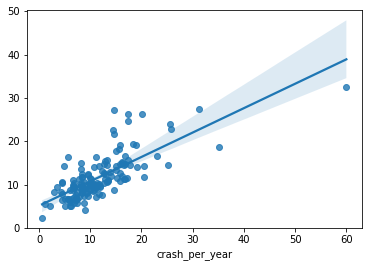

In [892]:
sns.regplot(y, pred)
# plt.xlim(0,80)
# plt.ylim(0,60)

### Plot residuals

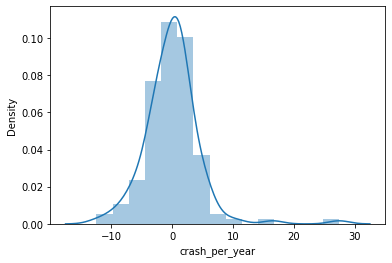

In [893]:
sns.distplot((y - pred), bins=15);

In [894]:

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y, pred)


Linear Regression Results:
Test set:
MAE: 3.0151762377547713
MSE: 20.467123365771634
RMSE: 4.524060495370462
R2 Square 0.5632861315591848


In [895]:
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))


     traffic: 7.59324343942954e-05
 total_lanes: 0.8928005243624364
       speed: 0.09797963896331768
violations_per_year: 0.02267315256983276
      n_cams: -0.46532001785943866
     one_way: -1.6095688987439947
  turn_lanes: 0.14428402489218964
         way: 2.4320522652483647


In [896]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y, pred) , cross_val(reg, X, y)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation Score (MSE)"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation Score (MSE)
0,Linear Regression,3.015176,20.467123,4.52406,0.563286,33.420509


In [897]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Ridge Model

In [898]:
from sklearn.linear_model import Ridge, RidgeCV

model = Ridge()
model.fit(X, y)
pred = model.predict(X)


print("Ridge Regression Results:")
print('=========================')
print_evaluate(y, pred)


Ridge Regression Results:
MAE: 3.010193686081585
MSE: 20.469692039921828
RMSE: 4.524344376804426
R2 Square 0.5632313228982486


In [899]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y, pred) , cross_val(model, X, y)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation Score (MSE)"])
results_df.append(ridge)

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation Score (MSE)
0,Linear Regression,3.015176,20.467123,4.524060,0.563286,33.420509
0,Ridge Regression,3.010194,20.469692,4.524344,0.563231,33.152677


## Random Forest Model

In [922]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric', 'active_cam',
       'traffic_per_lane', 'traffic', 'protected_ratio', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'speed',
       'n_cams', 'violations_per_year', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_non_incapacitating', 'days_active',
       'lanes_per_direction', 'region_id'],
      dtype='object')

In [944]:
forest_cont = ['traffic_per_lane', 'traffic', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'daily_traffic', 'speed',
       'n_cams', 'violations_per_year', 'lanes_per_direction', 'region_id']

forest_cat = ['region_id']


In [945]:
from sklearn.model_selection import train_test_split

X = crash_df.drop(columns=[target])
X = X[forest_cont]
y = crash_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [946]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 100, 
                               random_state = 0, 
                               max_features=10, 
                               max_depth=10,
                              )
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [947]:
y_pred = forest.predict(X_test)


In [948]:
# for plotting
df = pd.DataFrame({'val':y_test, 'pred':y_pred})

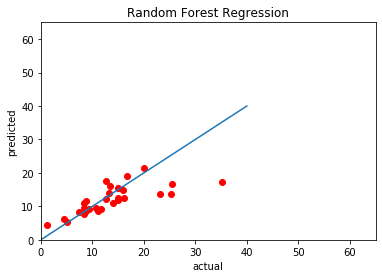

In [951]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# # Visualising the Random Forest Regression Results  
plt.scatter(y_test, y_pred, color = 'red')
plt.plot([0,40], [0, 40])
plt.title('Random Forest Regression')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.xlim(0,65)
plt.ylim(0,65)
plt.show()


In [950]:
print(forest.score(X_test, y_test))
df = pd.DataFrame(list(zip(X_test.columns, forest.feature_importances_)), columns=['feature', 'importance'])
df.sort_values(by='importance', ascending=False)

0.474695761677515


,feature,importance
20,violations_per_year,0.322525
4,total_lanes,0.127425
1,traffic,0.104287
17,daily_traffic,0.089314
15,lat,0.075680
2,complexity,0.058224
16,long,0.049508
22,region_id,0.030473
21,lanes_per_direction,0.027936
0,traffic_per_lane,0.024882


## Results of intersection characteristic analysis
Linear Regression gave the better results.  I kept it because of the better cross validation and the ability to interpret the results.  The r2 value is not as meaningful since we trained and scored on the same set. 

Characteristics used : 'traffic', 'total_lanes', 'medians', 'speed', 'violations_per_year', 'n_cams'
Most important characteristics (by rank): 'total_lanes', 'cams'

These characteristics accounted for about half of the crashes by r-square value.  Adding in more characteristics improves performance, but the individual p_vals do not support their inclusion, and would risk overfitting on a small dataset.

From our linear regression coefficients:
Every 50 violations is one more accident per year. (this is the best predictor we have)
A 6 way intersection will have about 5 more accidents per year. (2.5 per way)
Each additional lane adds about one accident per year.
An intersection with 10mph higher speed limit has one more accident per year.


Only a handful of the gathered characteristics meaningfully informed the model.
One possible hypothesis: dangerous intersections have had characteristics changed to mitigate the accidents.  Medians, no turns, protected turns, no left, cameras etc. were installed to make the intersection safer.  Perhaps they only occur at the more dangerous intersections, and their presence is the result rather than the cause of the accidents and should not be considered.  For this reason, I chose to only keep variables that were inherent to the intersection, and could not be mitigated (lanes, ways, traffic, violations, split, triangles, overpasses, exits).


The random forest model produced a higher score (MSE) than the linear model.  It used similar features (violations, lanes, and traffic added the most predictive value to the model)